# Load and initialize


settings


In [1]:
# sample number

j = '4.1'
# j = 'b23ad'
group_ind = 2
# n_samples = 10000
# create visualization (umap, dbscan are always shown)
visualize = True
plotUMAP = True
# show figures in notebook
show = True

saveSVG = False

# dir_data = 'Data_04042023'
dir_data1 = 'Data_'

calc_umap = False
create_adjusted = False


envirement


In [2]:

from tqdm import tqdm_notebook, tqdm
import datetime

import pandas as pd
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display
import sys
import pathlib
import os

import time
start = time.process_time()
date = datetime.date.today().strftime("%d%m%Y")
# import time

# import matplotlib

plt.rcParams["figure.figsize"] = (5.0, 4.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 180)  # according to screen width
# from pandas.core.base import PandasObject
# PandasObject.view = view #allows view meth pd.view

# from scipy import signal, stats
# import seaborn as sns

# from sklearn import metrics

# from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
# from sklearn.metrics import silhouette_samples,silhouette_score
# from sklearn.neighbors import kneighbors_graph

# from lmfit import minimize, Parameters


parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir+'/functions/')

# from epinuc import *
from usefull_functions import *
from functions import *
from plot_functions import *
from clustering_functions import *
from xg_shap import *    


%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%autoreload 2


# TF_ENABLE_ONEDNN_OPTS=0


/home/yishai/anaconda3/envs/tf_39/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


load data; normalized (CD45-)


In [3]:
j, group_ind, dir_data1 = getJ(j, group_ind, dir_data1)
dir_data = os.path.abspath(os.path.join(    parent_dir, os.pardir))+f'/{dir_data1}/'
dir_plots = os.path.abspath(os.path.join(
    parent_dir, os.pardir))+f'/_sample_{j}_{dir_data1}_{date}/'
folderExists(dir_plots)
settings = (dir_plots, show, saveSVG)

if 'b' not in j:
    singleSample = True
else:
    singleSample = False
print(f'singleSample is: {singleSample}')

# k_orig = pickle_load('k'+j+'_dict',dir_data )['k']
# k = k_orig.copy()
# CAll=pd.concat([k]).copy()

k = pickle_load('k'+j+'_dict', dir_data)['k']
CAll = pd.concat([k.copy()])
print(len(k))


names_dict = pickle_load('k'+j+'_names_dict', dir_data)
NamesAll = names_dict['NamesAll']
CellIden = names_dict['CellIden']
EpiCols = names_dict['EpiCols']
Core = names_dict['Core']
CellIden_EpiCols = CellIden + EpiCols
# dict = None

groups = [['CellIden', 'EpiCols', 'CellIden+EpiCols'],
          [CellIden, EpiCols, CellIden_EpiCols]]

names = [[f'samp{j}_CellIden_', f'samp{j} CellIden Based'],
         [f'samp{j}_EpiCols_', f'samp{j} EpiCols Based'],
         [f'samp{j}_CellIden+EpiCols_', f'samp{j} CellIden+EpiCols Based']]

params = ['iden', 'epi', 'all']


current j = 4.1,group_ind = 2, add = Data_
The new directory is created!
singleSample is: True
k4.1_dict ; loaded from file
5000
k4.1_names_dict ; loaded from file


Visualize data

no point to print data.describe() as it is whitened (std~1, mean~0)


In [4]:
# if show:

#     for features in [NamesAll,Core,CellIden,EpiCols,CellIden_EpiCols]:
#         print(len(features))
#         print(features)


# Cell Identity


In [5]:

figname, title = names[group_ind]
name, featureGroup = groups[0][group_ind], groups[1][group_ind]
print(name, title, figname)


CellIden+EpiCols samp4.1 CellIden+EpiCols Based samp4.1_CellIden+EpiCols_


### UMAP

plot for each feature according to its intensity


min_dist:0.1, n_neighbors:10
umapData_samp4.1_CellIden+EpiCols_ ; loaded from file


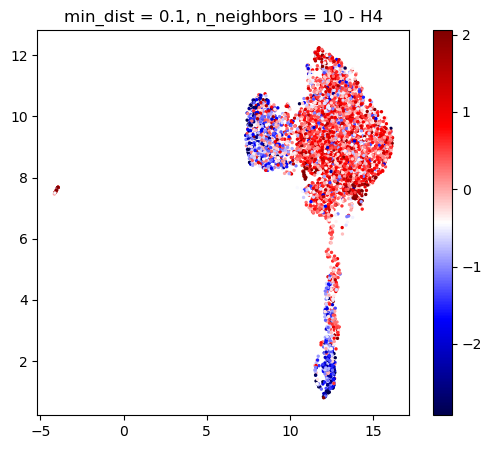

In [6]:

min_dist, n_neighbors = getValsCsv(    dir_data, vars=[params[group_ind], 'umap', j])
# min_dist, n_neighbors = 0.02,10
print(f'min_dist:{min_dist}, n_neighbors:{n_neighbors}')
# calc_umap = True
if calc_umap:
    umapData = calculate_umap(CAll[featureGroup].copy(), n_neighbors, min_dist)
    pickle_dump(f'umapData_{figname}', umapData, dir_data)
else:
    umapData = pickle_load(f'umapData_{figname}', dir_data)
drawUMAP(umapData, ['H4'], CAll, settings,
         title=f'min_dist = {min_dist}, n_neighbors = {n_neighbors}',
         Figname='1_'+figname+'UMAP_(core)')


### Dbscan and clusters


Dbscan


0.16 65
Estimated number of clusters: 6
Estimated number of noise points: 389
Silhouette Coefficient: 0.291


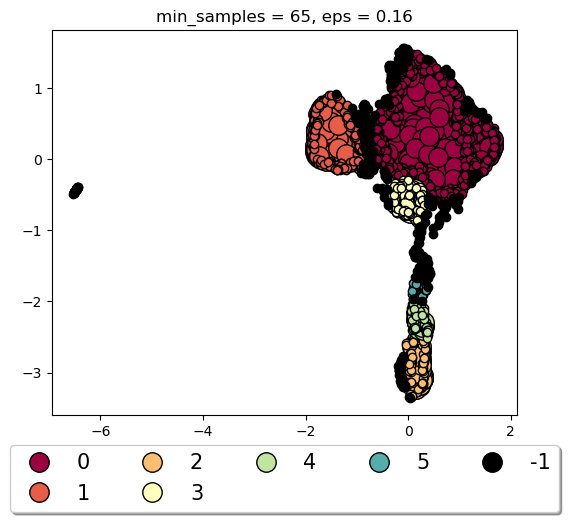

In [7]:

eps, min_samples = getValsCsv(dir_data, vars=[params[group_ind], 'db', j])
# eps,min_samples = 0.12,180
print(eps, min_samples)

dbscanData, labels, core_samples_mask  = calculate_dbscan(umapData,list(k.index), eps, min_samples)


colors = drawDbscan(dbscanData, labels, core_samples_mask, settings,

                    title=f'min_samples = {min_samples}, eps = {eps}',

                    figname='1_'+figname+'dbscan')
pickle_dump(f'dbLabels_{figname}', labels, dir_data)
pickle_dump(f'dbColors_{figname}', colors, dir_data)





adjusted dataset


In [8]:
# def load_adjusted(j,k,dir_indexes):
#     # k = k[j].copy()
#     Ind, by_sample= pickle_load(f"{j}_adjusted_subsample_indexes",dir_indexes)
#     uniq = [int(i) if i != 4.1 else float(i)  for i in np.unique(by_sample)]
#     # appendDict ={}
    
#     k_append= pd.DataFrame()
#     for samp in uniq:
#         K=k[k['by_sample']==samp].copy()
#         samp_idx = Ind[by_sample ==samp]
        
#         kInd = [True if (i in samp_idx) else False for i in np.asarray(K.Ind)]
#         K = K[kInd]
#         k_append = pd.concat([k_append,K.copy()], ignore_index=True,axis=0,)
#     return k_append

if j == 'b23' and group_ind==2 and create_adjusted:
    dir_indexes = os.path.abspath(os.path.join(parent_dir, os.pardir))+'/indexes/'

    clusters = [0, 2, 8]  # clusters to keep
    ind = ~np.zeros_like(labels).astype(bool)
    for cluster in clusters:
        ind *= ~(labels == cluster)
    # ind =~ind
    ind = np.asarray([i for i, j in enumerate(~ind) if j])

    
    newK = k.loc[ind].copy().reset_index(drop = True)
    pickle_dump(f"{j}_adjusted_subsample_indexes", [ np.asarray(newK.Ind),np.asarray(newK.by_sample) ],dir_indexes)
    # k_append = load_adjusted(j,k,dir_indexes)
    
        # appendDict[samp ] = K[kInd]
    

        
    

    # # sort
    # df = pd.DataFrame(columns = newK.columns,index = newK.index)
    # for i,s,m in zip(newK.index,newK.Ind,newK.by_sample):
    #     df.loc[i] = k_append[k_append['Ind']==s][k_append['by_sample']==m].values
    # q=(df==newK).T.all();ind = q[~q.values].index
    # print(q.all())


    # dict = {'k':k}
    # pickle_dump('kb23_adjusted_dict', {'k': newK}, dir_data)
    # pickle_dump('kb23_adjusted_names_dict', names_dict, dir_data)
    # print('new k saved')

    # pickle_dump(f'sampb23_adjusted_CellIden+EpiCols_', umapData[ind], dir_data)

    colors = drawDbscan(dbscanData[ind], labels[ind], core_samples_mask[ind], settings,
                        title=f'min_samples = {min_samples}, eps = {eps}',
                        figname='1_'+figname+'dbscan_adjusted')
    # plotClusters(newK, umapData[ind], labels[ind], colors, NamesAll, settings,
    #              title='Clusters ' + title,
    #              figname='1_'+figname+'Clusters_adjusted')


clusters

### HeatMap by clusters


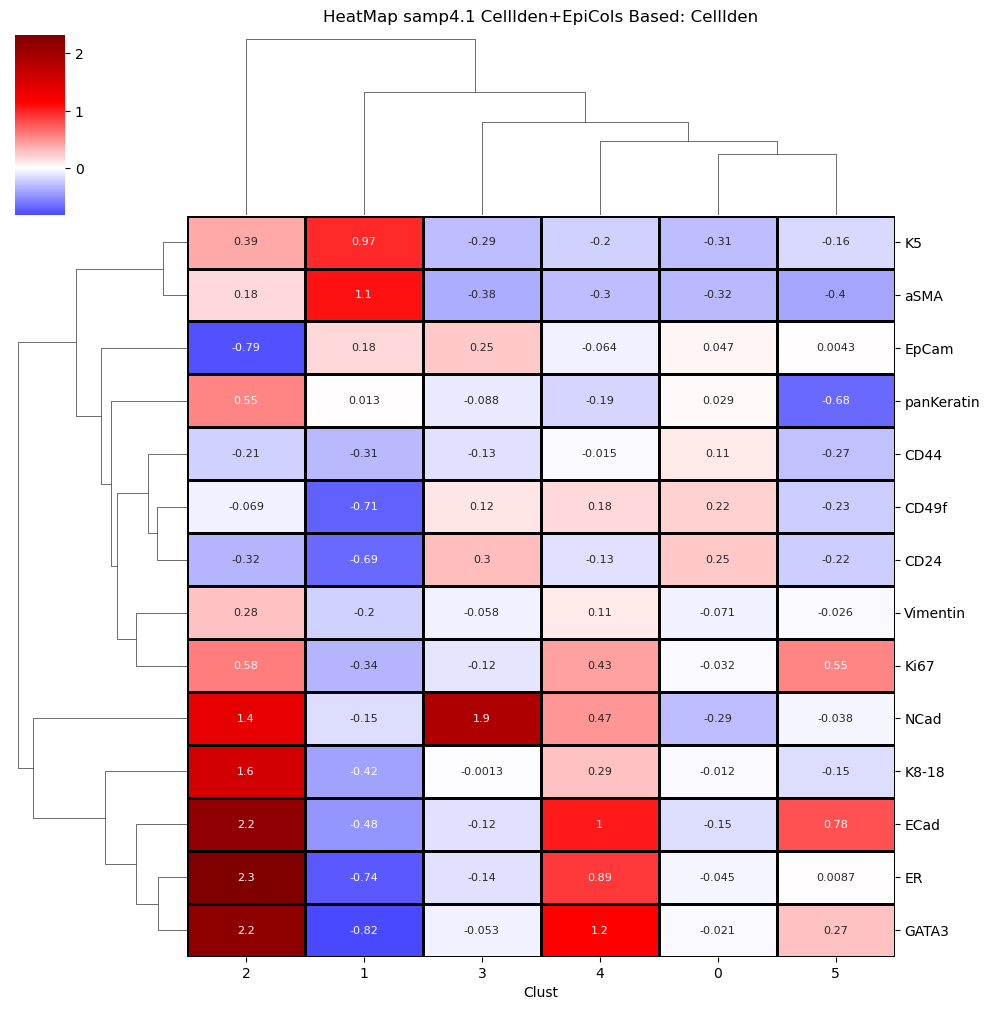

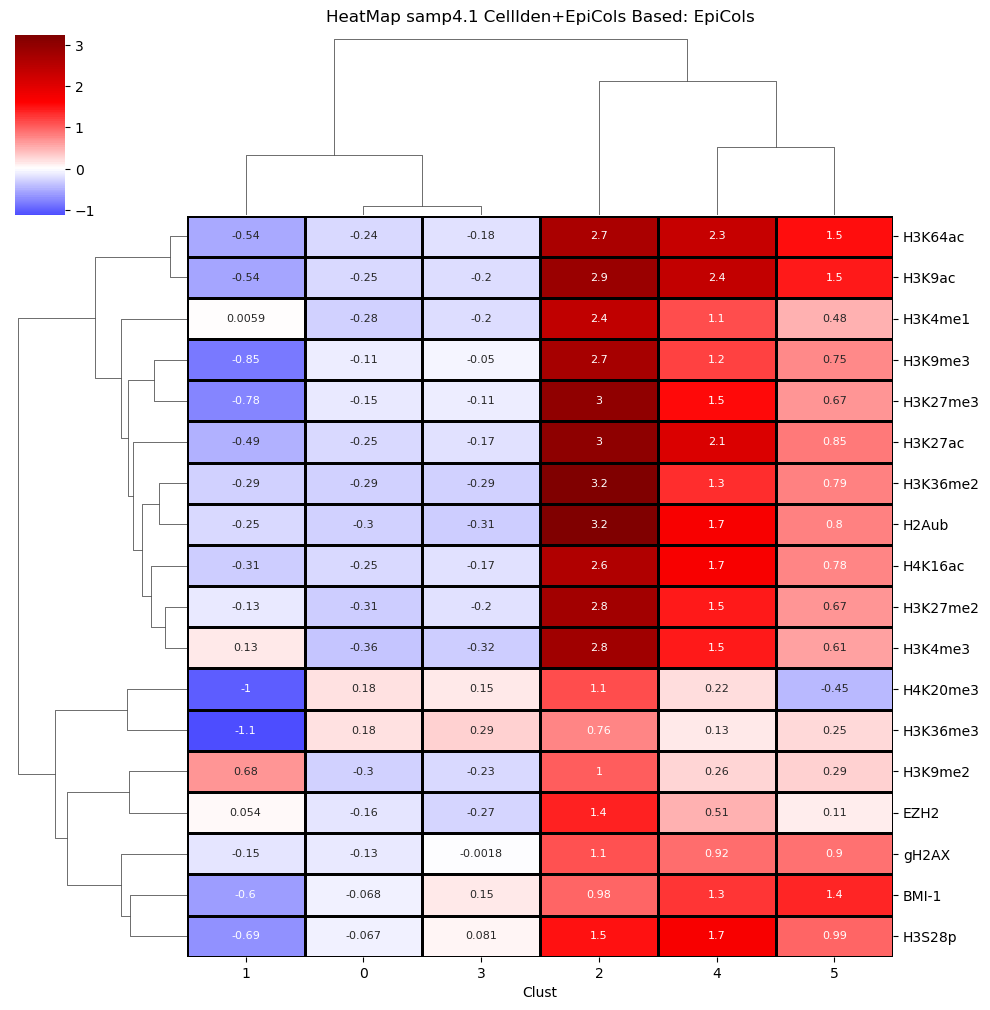

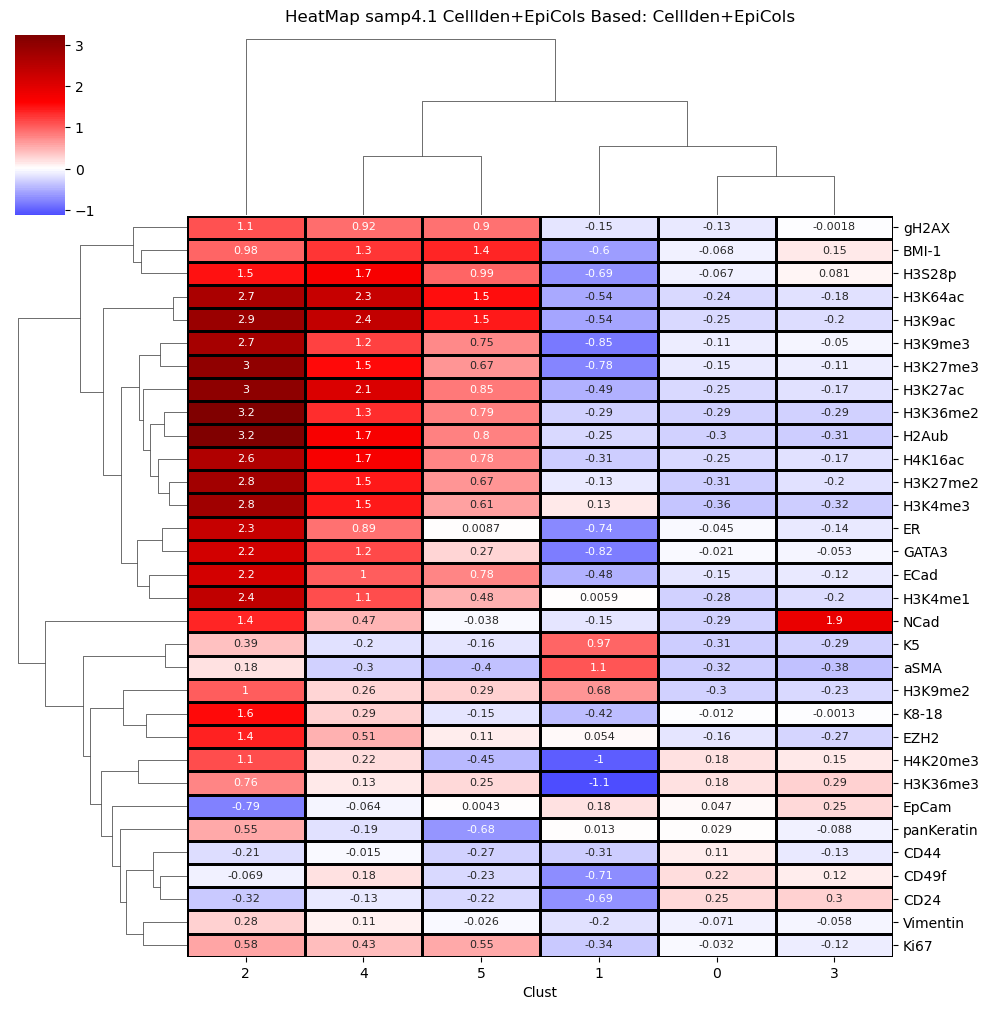

In [9]:
if visualize:
    k['Clust'] = labels
    for group_name, group in zip(groups[0], groups[1]):
        HeatMap(k[labels != -1], group, settings,clustFeature='Clust',
                title='HeatMap ' + title + ': '+group_name,
                figname='1_'+figname+'ClustHeatMap_by_'+group_name)
    


specific clusters and features

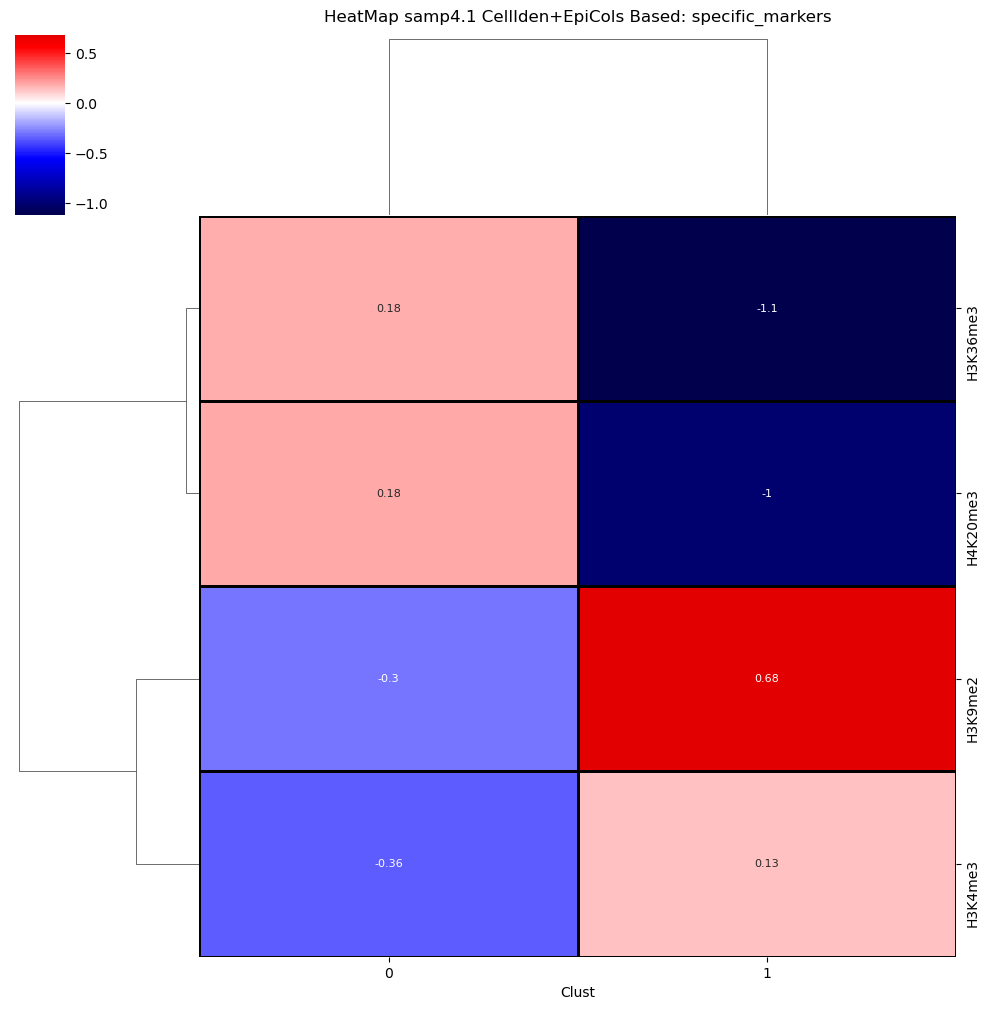

In [20]:
from plot_functions import *
if visualize:
    clusters =[0,1]
    group_name, group = 'specific_markers', ['H3K9me2', 'H3K4me3','H3K36me3','H4K20me3']
    kk=k.copy()
    # -----------------
    k = k.loc[[True if c in clusters else False for c in k['Clust'] ]]
    HeatMap(k, group, settings,clustFeature='Clust',
    title='HeatMap ' + title + ': '+group_name,
                figname='1_'+figname+'ClustHeatMap_by_'+group_name)
    # ---------------------
    k=kk.copy()
    kk = None



### HeatMap by sample


In [11]:
if visualize and not singleSample:
    group_name, group = groups[0][-1], groups[1][-1]
    HeatMap(k[labels != -1], group, settings, clustFeature='by_sample',
            title='HeatMap ' + title + ': ' + group_name+' by_sample',
            figname='1_'+figname+'SampHeatMap_'+group_name)


### MeanDist


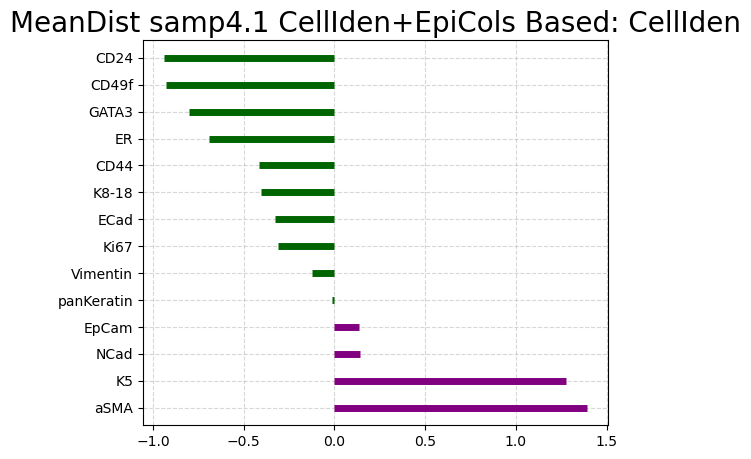

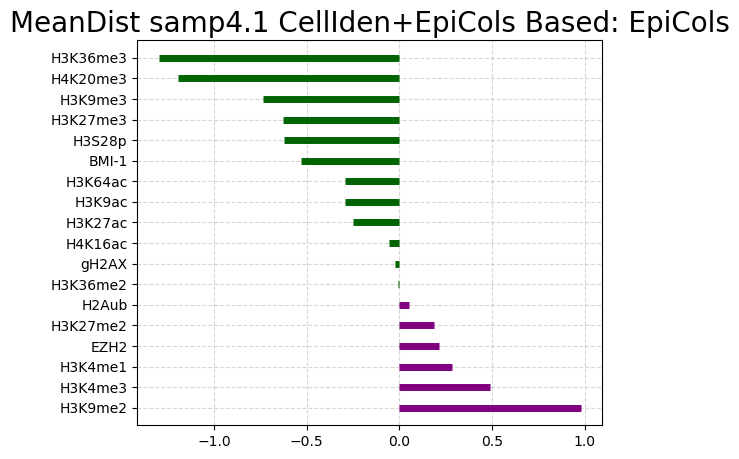

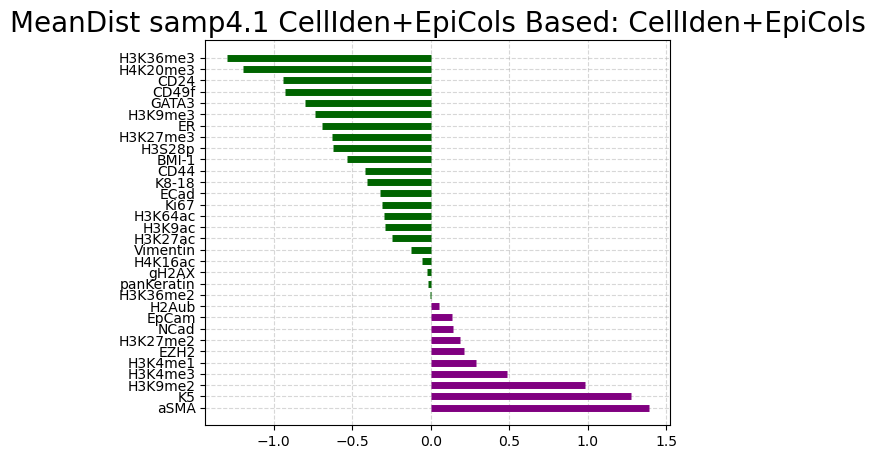

In [12]:

if visualize:
    for group_name, group in zip(groups[0], groups[1]):
        MeanDist(k[labels == 0], k[labels == 1], group, settings,
                 title='MeanDist ' + title + ': '+group_name,
                 figname='1_'+figname+'ClustMeanDist_by_'+group_name)


## sample percentage


by sample

In [13]:
# from plot_functions import *
if visualize and not singleSample:
    # unique by_sample values
    for sampNum in np.unique(k['by_sample']):
        ind_samp = [i for i, j in enumerate(k.by_sample == sampNum) if j]
        labels_samp = np.ones(len(ind_samp))*sampNum
        drawUMAPbySample(umapData, k, ind_samp, labels_samp, settings,
                         title=title+f' UMAP - by_sample={sampNum}',
                         Figname='4_'+figname+f'UMAP_sample{sampNum}_by_sample')
    arr = []
    clustNums = np.unique(k.Clust)
    clustNums = clustNums[clustNums != -1]
    for clustNum in clustNums:
        ind = k.Clust == clustNum
        PercentageBySample = ClustPercentageBySample(k[ind], 'by_sample')

        arr.append([clustNum, PercentageBySample])
    saveCsv(dir_plots, figname, arr)


all samples

In [14]:
from plot_functions import *


if visualize and not singleSample:
    # remove 4.1,7.1 and subsample 
    ind_samp =k.index.values[[ True  if i!='4.1' and i!='7.1' else False for i in k.by_sample]]
    ind_samp=np.random.choice(ind_samp, replace = False, size = int(len(k)/4))
    # ind_samp = k.index.values
    labels_samp = np.asarray(k.by_sample).astype(int)[ind_samp]

    colors_samp = np.zeros((np.max(labels_samp)+2,4))
    hex = ['00B3A4','3185FC','DB1374','490092','FEB6DB','F98510','E6C220','BFA180','920000','461A0A']
    colors_samp[1+np.unique(labels_samp)] = np.asarray([hex_to_rgba(h) for h in hex])[:np.unique(labels_samp).shape[0]]
    drawUMAPbySample(umapData, k, ind_samp, labels_samp, settings,colors_samp,backgroundColor = 'white',
                        title=title+f' UMAP - by_sample=ALL',
                        Figname='4_'+figname+f'UMAP_sampleAll_by_sample')
 


by cluster

dbLabels_samp4_CellIden+EpiCols_ ; loaded from file
dbColors_samp4_CellIden+EpiCols_ ; loaded from file


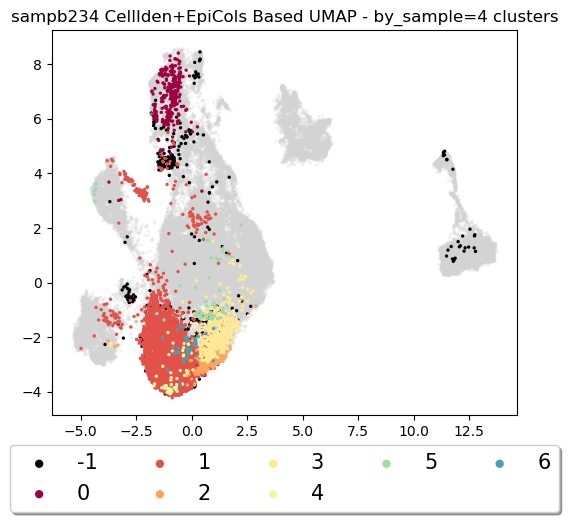

dbLabels_samp4.1_CellIden+EpiCols_ ; loaded from file
dbColors_samp4.1_CellIden+EpiCols_ ; loaded from file


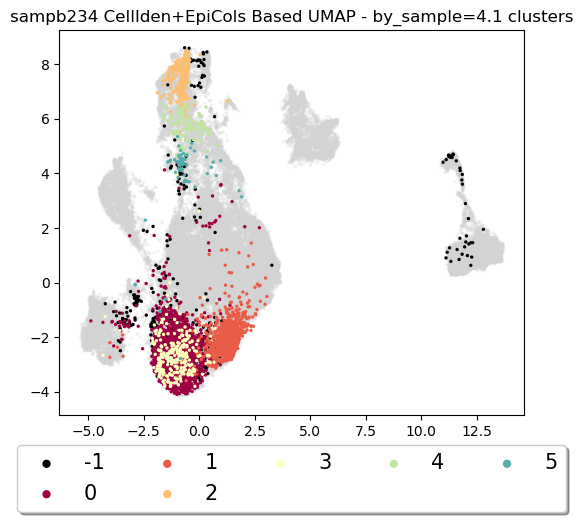

dbLabels_samp5_CellIden+EpiCols_ ; loaded from file
dbColors_samp5_CellIden+EpiCols_ ; loaded from file


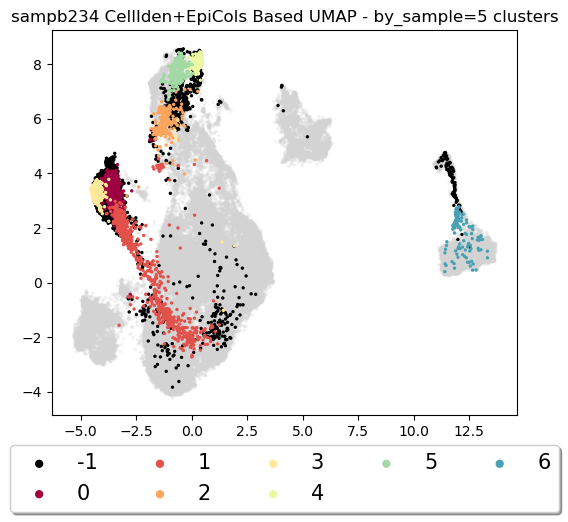

dbLabels_samp7_CellIden+EpiCols_ ; loaded from file
dbColors_samp7_CellIden+EpiCols_ ; loaded from file


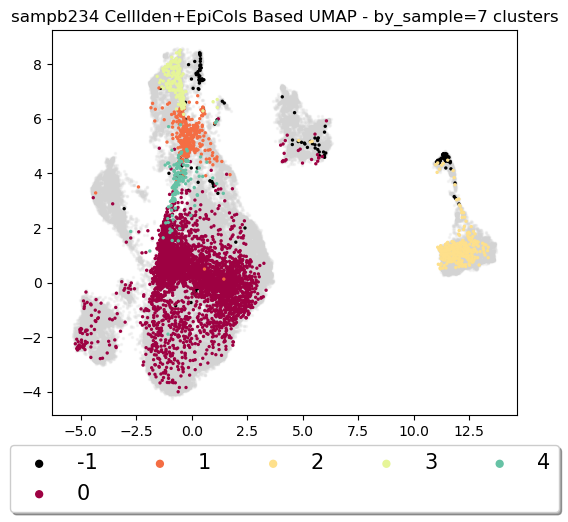

dbLabels_samp7.1_CellIden+EpiCols_ ; loaded from file
dbColors_samp7.1_CellIden+EpiCols_ ; loaded from file


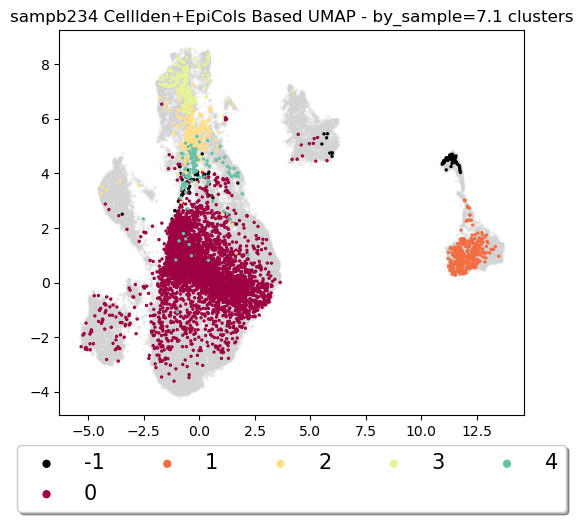

dbLabels_samp8_CellIden+EpiCols_ ; loaded from file
dbColors_samp8_CellIden+EpiCols_ ; loaded from file


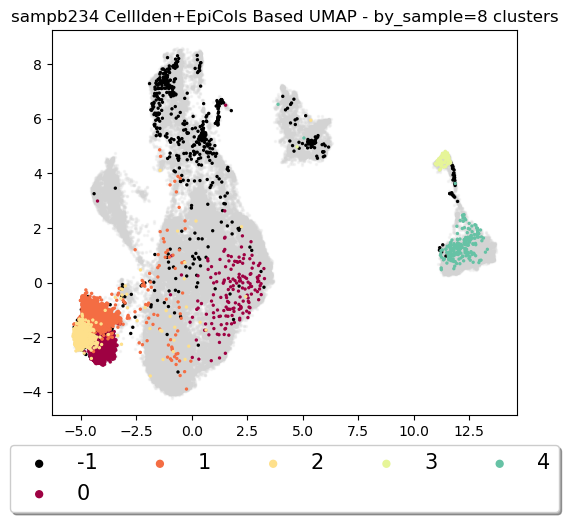

dbLabels_samp11_CellIden+EpiCols_ ; loaded from file
dbColors_samp11_CellIden+EpiCols_ ; loaded from file


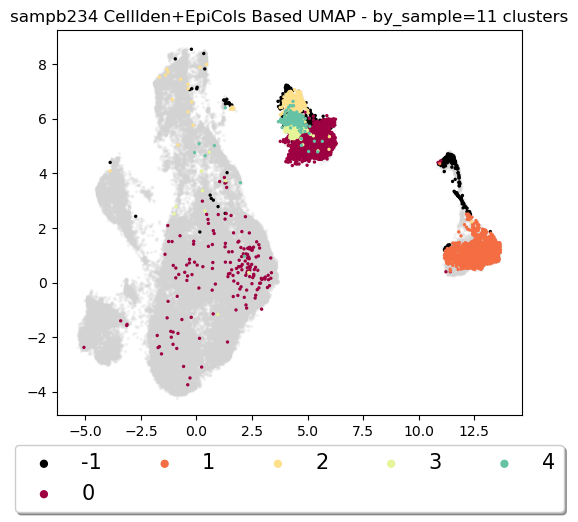

dbLabels_samp13_CellIden+EpiCols_ ; loaded from file
dbColors_samp13_CellIden+EpiCols_ ; loaded from file


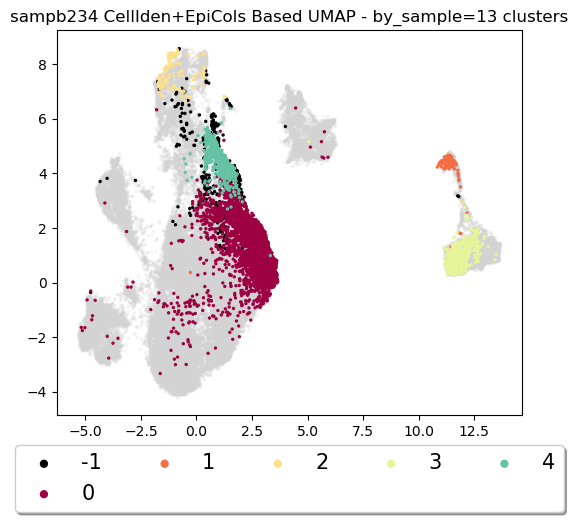

dbLabels_samp14_CellIden+EpiCols_ ; loaded from file
dbColors_samp14_CellIden+EpiCols_ ; loaded from file


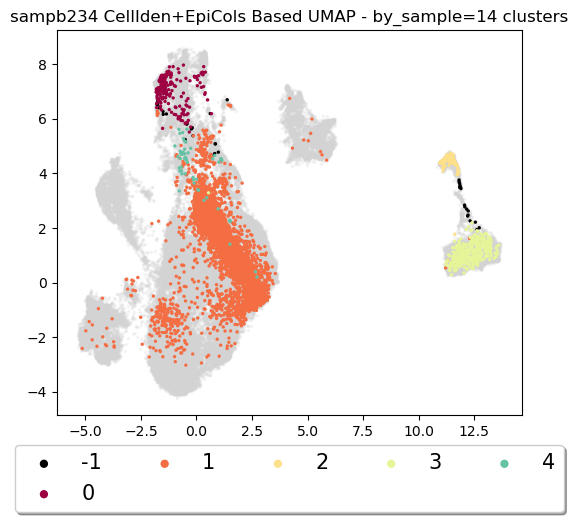

dbLabels_samp15_CellIden+EpiCols_ ; loaded from file
dbColors_samp15_CellIden+EpiCols_ ; loaded from file


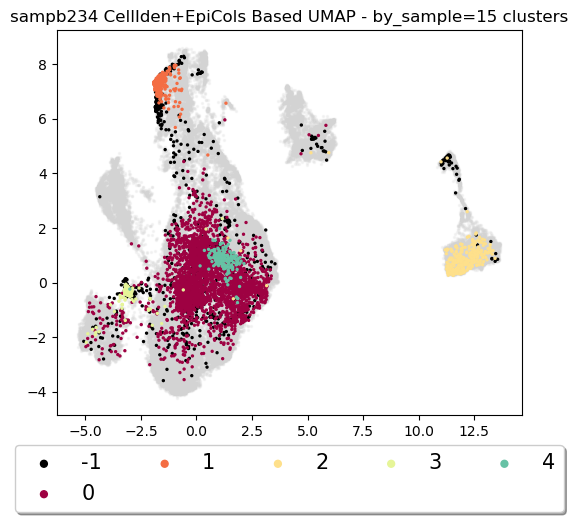

In [66]:
from plot_functions import *
if visualize and not singleSample:
    # plt.scatter(umapData[:,0],umapData[:,1],c = 'lightgrey', alpha=0.2,s=2)
    uniq = [int(i) if (np.round(i,1) - np.round(i,0)==0) else float(i)  for i in np.unique(k['by_sample'])]
    # print(uniq)
    # unique by_sample values
    for sampNum in uniq:
        # sampNum = uniq[-1]

        # ind_umap = [i for i, j in enumerate(k.by_sample == sampNum) if j]
        # labels_samp = np.asarray(pickle_load(f'dbLabels_samp{sampNum}_{name}_', dir_data))
        
        # sample indexs which are the full dataset - filter db labels by it
        ind_samp = [i for i, j in zip(k.Ind,k.by_sample == sampNum) if j]
        # corresponding indexes in the full data set - where each point in the full umap
        ind_umap = [i for i, j in zip(k.index,k.by_sample == sampNum) if j]        
        labels_samp = np.asarray(pickle_load(f'dbLabels_samp{sampNum}_{name}_', dir_data))[ind_samp]
        # colors_samp = pickle_load(f'dbColors_samp{sampNum}_{name}_', dir_data)
        colors_samp = np.vstack(([0,0,0,1],np.asarray(pickle_load(f'dbColors_samp{sampNum}_{name}_', dir_data))))
        # pickle_dump(f'dbColors_{figname}', colors, dir_data)

        drawUMAPbySample(umapData, k, ind_umap, labels_samp, settings,colors_samp,
                         title=title+f' UMAP - by_sample={sampNum} clusters',
                         Figname='4_'+figname+f'UMAP_sample{sampNum}_by_sample_clusters')
        
# [4, 4.1, 5, 7, 7.1, 8, 11, 13, 14, 15]


## features on UMAP


shap

In [ ]:
if visualize and plotUMAP:
    ind = labels !=-1 # drop unclustered rows (clust==-1)
    accuracy = xg_classification_shap(CAll[featureGroup].copy(),labels.copy(),ind,colors,
                                    settings,figname='5_'+figname+'shap', calc_shap = True)
    print(f"accuracy {j}_{group_ind}: {accuracy}%")




plot Clusters

In [ ]:
if visualize and plotUMAP:
    plotClusters(k, umapData, labels, colors, NamesAll, settings,
                title='Clusters ' + title,
                figname='1_'+figname+'Clusters')

plot features on umap 

In [ ]:
if visualize and plotUMAP:
    drawUMAP(umapData, NamesAll, CAll, settings,
             title='UMAP ' + title,
             Figname='2_'+figname+'UMAP_')


## scatter figures


In [ ]:
if visualize:
    try:
        scatter(k, 'NCad', 'ECad', title, figname, settings)
    except:
        print('no ncad in sample')


## clear data


In [ ]:
# dbscanData, umapData,k, CAll,labels = None,None,None,None,None
# imList2pdf(dir_plots,j,['CellIden','EpiCols','CellIden+EpiCols'])
